# Development of LightGBM, MLP Classifier, and Random Forest Models for OTTO Group Product Classification

#### Author: Brendan Donnelly
#### Course: Intro to Machine Learning Applications
#### Date: December 12, 2020

In [1]:
#!pip3 install seaborn
#!pip3 install xgboost
#!pip3 install sklearn
#!pip3 install lightgbm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgbm

from sklearn import metrics, calibration
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import neighbors, cluster, feature_selection
from sklearn.ensemble import RandomForestClassifier

In [2]:
# files gathered from url: https://www.kaggle.com/c/otto-group-product-classification-challenge/data 
test = pd.read_csv(r"C:\Users\donneb\Documents\MachineLearning\otto-group-product-classification-challenge\test.csv").set_index("id")
train = pd.read_csv(r"C:\Users\donneb\Documents\MachineLearning\otto-group-product-classification-challenge\train.csv")

In [3]:
#splitting features
train_no_id = train.drop(['id'], axis = 1)
train_class = train['target']
train_X = train.drop(['target','id'], axis = 1)

## Exploratory Data Analysis

In [4]:
train.head()
train.tail()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9
61877,61878,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,Class_9


In [5]:
# NA check
na_train = train.isnull().values.any()
na_test = test.isnull().values.any()

print("Are there NAs in train: " + str(na_train) )
print("Are there NAs in test: " + str(na_test ) )

Are there NAs in train: False
Are there NAs in test: False


In [6]:
train.columns
test.columns

Index(['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7',
       'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13',
       'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19',
       'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25',
       'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31',
       'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36', 'feat_37',
       'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42', 'feat_43',
       'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49',
       'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55',
       'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60', 'feat_61',
       'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66', 'feat_67',
       'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72', 'feat_73',
       'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78', 'feat_79',
       'feat_80', 'feat_81', 'feat_82', 'feat_83'

In [7]:
#unique target vars
train_class.unique()

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [8]:
#description of percentiles, mean, std_dev, count, and max of train data set
train.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


In [9]:
#Slight Pre-Processing -> Label encoding string to numeric target [0-8]
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train['target']=le.fit_transform(train['target'])
train['target']

0        0
1        0
2        0
3        0
4        0
        ..
61873    8
61874    8
61875    8
61876    8
61877    8
Name: target, Length: 61878, dtype: int32

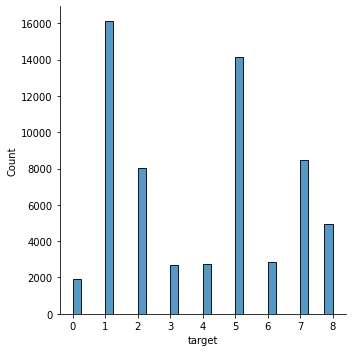

In [10]:
import seaborn as sns
sns.displot(x = train['target'])

<AxesSubplot:>

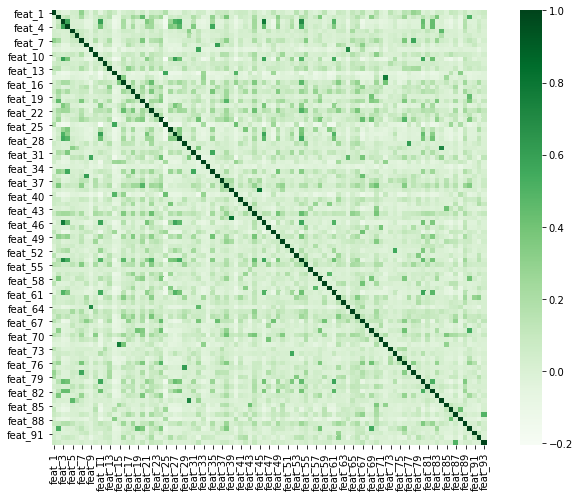

In [11]:
# Large Feature Corr Plot
corr = train_no_id.corr()
plt.figure(figsize=(12,8))
sns.heatmap(
    corr, 
    cmap="Greens",
    square=True
)

<AxesSubplot:>

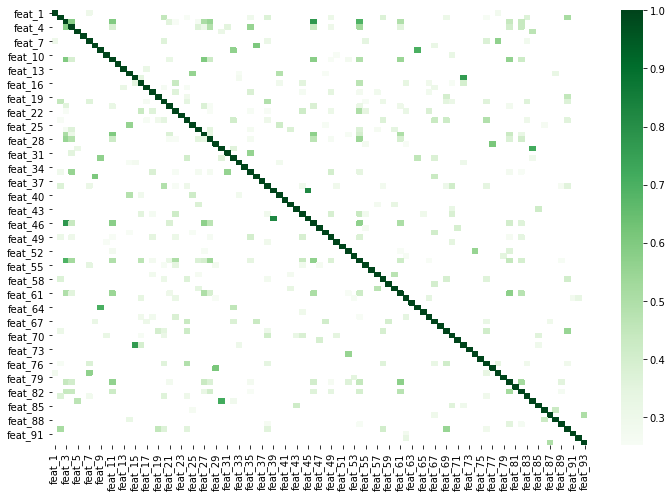

In [12]:
#Heatmap Highlighting Correlation > .25
quarter_corr = corr[corr>=.25]
plt.figure(figsize=(12,8))
sns.heatmap(quarter_corr, cmap="Greens")

# LightGBM Model:

#### Feature Pre-ProcessingTFIDF

In [13]:
#developing class dictionaries for later transformation of test df to class predictions dataframe
class_to_order = dict()
order_to_class = dict()

for idx, col in enumerate(train_class.unique()):
    order_to_class[idx] = col
    class_to_order[col] = idx

feature_columns = [col for col in train.columns if col.startswith("feat_")]

In [14]:
# train-test-split 70-30
X_train, X_valid, y_train, y_valid = train_test_split(
    train_X, train['target'],
    test_size=0.3, random_state=123,
    stratify=train['target']
)

tfidf = TfidfTransformer()
tfidf_feature_train = tfidf.fit_transform(X_train).toarray().astype("float32")
tfidf_feature_valid = tfidf.transform(X_valid).toarray().astype("float32")

In [15]:
tfidf_feature_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.252369  , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12440598, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.28182772, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [16]:
X_train_tfidf = np.hstack((X_train.values, tfidf_feature_train))
X_valid_tfidf = np.hstack((X_valid.values, tfidf_feature_valid))

In [17]:
# used this section for parameter tuning for lgbm model
# random seed 123- doesnt matter, multiclass and multi_logloss w/ 9 classes given from project needs, bagging fraction = default, bagging_freq=default
# feature_fraction tinkered with values 0-1

params = {
    'objective': "multiclass",
    'metric': {"multi_logloss"},
    'num_class': 9,
    'seed': 123,
    'feature_fraction': 0.4,
}

In [18]:
dataset_train = lgbm.Dataset(X_train_tfidf, y_train)
dataset_valid = lgbm.Dataset(X_valid_tfidf, y_valid)

#### LGBM Model Generation

In [19]:
lgbm_model = lgbm.train(
    params,
    dataset_train,
    feature_name=([f"feat_{i}" for i in range(1, 94)] + [f"tfidf_{i}" for i in range(1, 94)]),
    num_boost_round=500,
    valid_sets=dataset_valid,
    early_stopping_rounds=20,
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26747
[LightGBM] [Info] Number of data points in the train set: 43314, number of used features: 186
[LightGBM] [Info] Start training from score -3.468371
[LightGBM] [Info] Start training from score -1.345001
[LightGBM] [Info] Start training from score -2.045174
[LightGBM] [Info] Start training from score -3.135079
[LightGBM] [Info] Start training from score -3.117714
[LightGBM] [Info] Start training from score -1.476547
[LightGBM] [Info] Start training from score -3.081850
[LightGBM] [Info] Start training from score -1.989295
[LightGBM] [Info] Start training from score -2.524610
[1]	valid_0's multi_logloss: 1.63084
Training until validation scores don't improve for 20 rounds
[2]	valid_0's multi_logloss: 1.44771
[3]	valid_0's multi_l

#### Model Results

In [20]:
best_iter_lgbm = lgbm_model.best_iteration
print(best_iter_lgbm)

#[163]	valid_0's multi_logloss: 0.487458

163


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

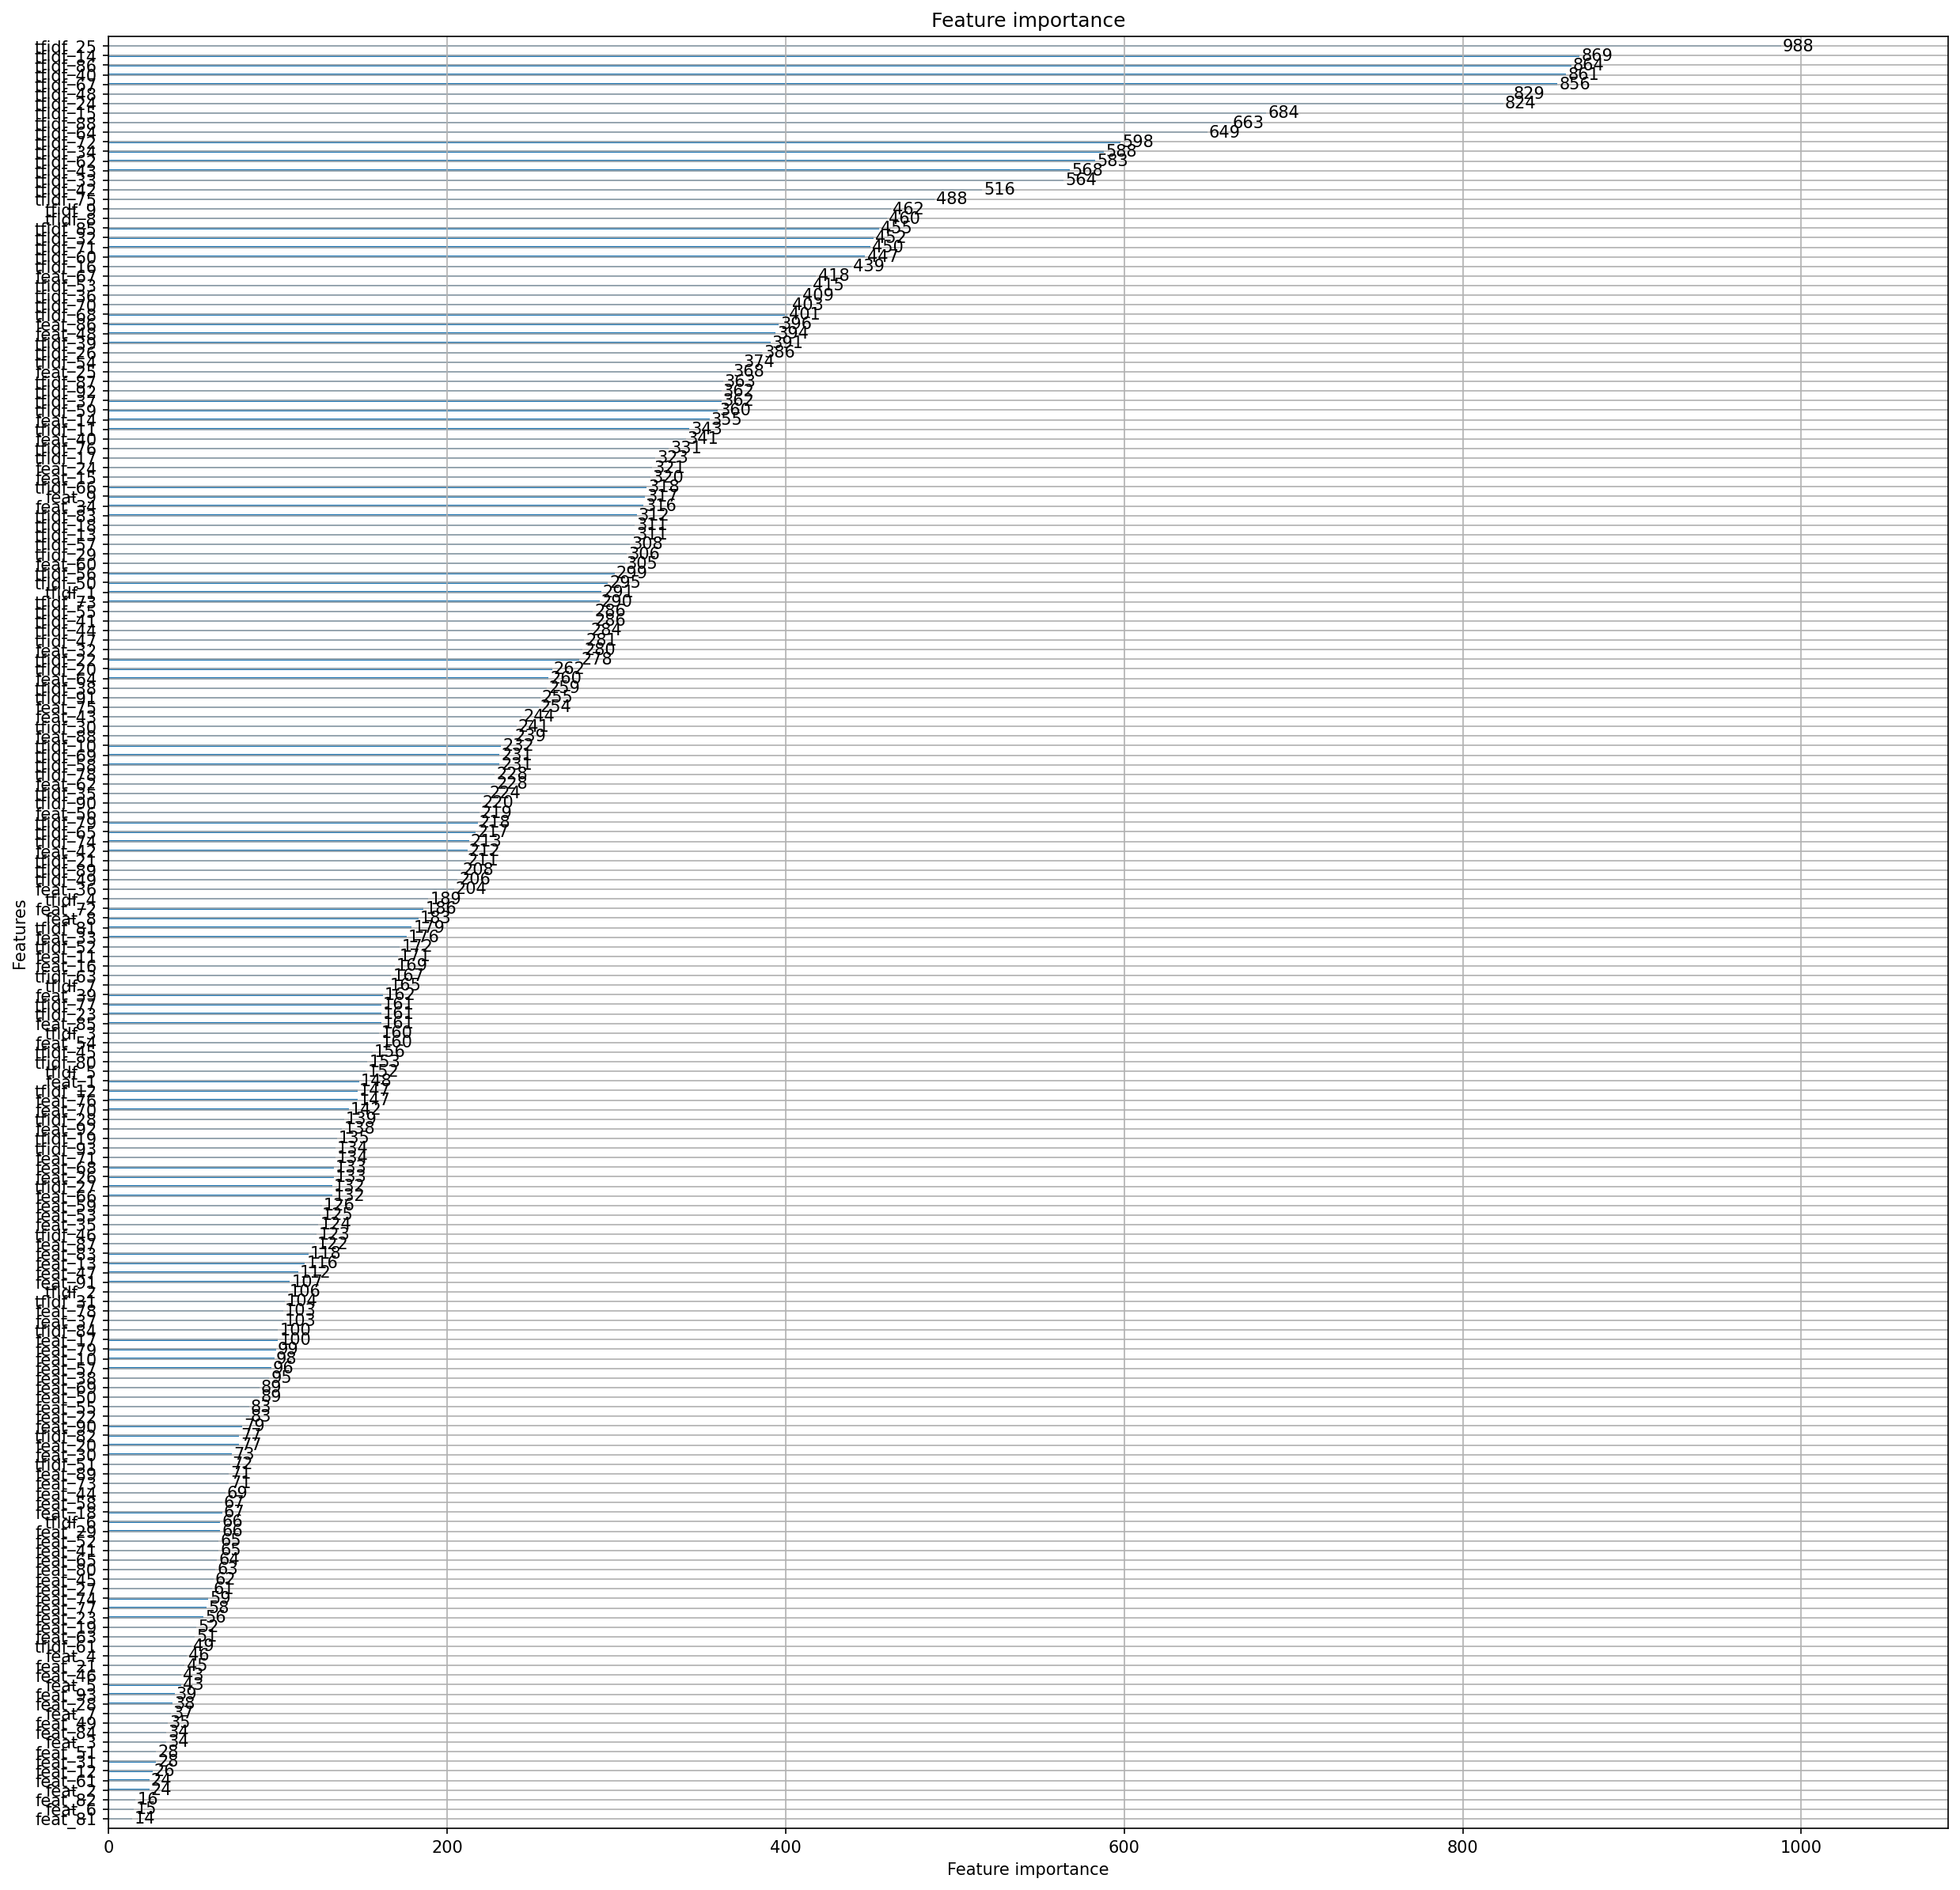

In [21]:
lgbm.plot_importance(
    lgbm_model,
    figsize=(20, 20),
    dpi=150,
)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

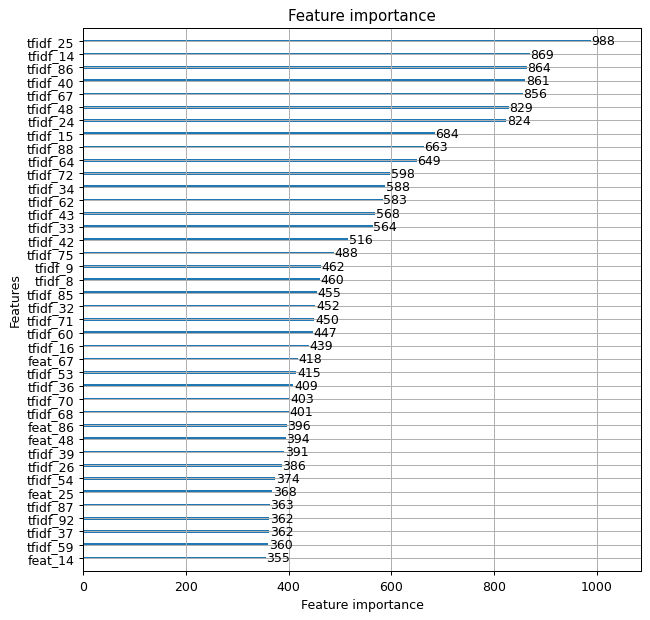

In [22]:
lgbm.plot_importance(
    lgbm_model,
    max_num_features=40,
    figsize=(8, 8),
    dpi=90,
)

In [23]:
test

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,3,...,0,0,11,1,20,0,0,0,0,0
2,2,2,14,16,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
3,0,1,12,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
5,1,0,0,1,0,0,1,2,0,3,...,0,0,0,0,0,0,0,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144364,0,0,0,0,0,0,0,0,0,1,...,0,0,2,1,1,0,0,0,0,0
144365,0,0,0,0,0,0,0,0,0,0,...,0,1,4,1,11,0,0,0,0,0
144366,0,1,0,0,0,0,1,1,0,0,...,0,1,3,1,1,0,0,1,0,0


## Generating Model Predictions for Test data
### Generating Submission of Predictions in proper CSV format

In [24]:
#index ordering dictionaries 
class_to_order = dict()
order_to_class = dict()

for idx, col in enumerate(train_class.unique()):
    order_to_class[idx] = col
    class_to_order[col] = idx

In [25]:
tfidf_feature_test = tfidf.transform(test).toarray()
X_test_tfidf = np.hstack((test[feature_columns].values, tfidf_feature_test))

#apply model to predict classes in test dataset
pred = lgbm_model.predict(X_test_tfidf)

#transform test dataframe to class columns, predictions for rows
for idx, col in order_to_class.items():
    test[col] = pred[:,idx]

#save submission df
lgbm_submission = test[[f"Class_{i}" for i in range(1, 10)]]
lgbm_submission

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
id,,,,,,,,,
1,0.000415,0.087464,0.180651,0.723506,5.082353e-06,0.000404,0.007409,0.000083,0.000063
2,0.000561,0.005491,0.000753,0.000101,2.107649e-05,0.886475,0.000755,0.103545,0.002298
3,0.000006,0.000020,0.000013,0.000013,2.350652e-08,0.999356,0.000012,0.000554,0.000025
4,0.000360,0.433753,0.555393,0.009368,4.259872e-07,0.000082,0.000097,0.000227,0.000719
5,0.141986,0.002185,0.000708,0.000391,1.450453e-06,0.004913,0.005844,0.151555,0.692416
...,...,...,...,...,...,...,...,...,...
144364,0.580957,0.008308,0.004382,0.007090,8.263602e-07,0.347118,0.025197,0.011836,0.015111
144365,0.002100,0.322894,0.510128,0.065253,5.065894e-06,0.000666,0.098633,0.000097,0.000224
144366,0.000416,0.584585,0.271541,0.138547,5.107069e-07,0.000902,0.003557,0.000253,0.000199


In [26]:
#convert to csv file for kaggle submission
lgbm_submission.to_csv('lgbm_submission.csv', index=True)

# MLP Classifier Model

In [27]:
#reset some preprocessing from other model
test = pd.read_csv(r"C:\Users\donneb\Documents\MachineLearning\otto-group-product-classification-challenge\test.csv")

In [28]:
model = MLPClassifier(hidden_layer_sizes=(30,10), random_state = 1, verbose = True)
model.fit(train_X, train['target'])

Iteration 1, loss = 1.21744393
Iteration 2, loss = 0.71624981
Iteration 3, loss = 0.65377488
Iteration 4, loss = 0.62358279
Iteration 5, loss = 0.60419073
Iteration 6, loss = 0.59072354
Iteration 7, loss = 0.57952244
Iteration 8, loss = 0.57021663
Iteration 9, loss = 0.56224871
Iteration 10, loss = 0.55539223
Iteration 11, loss = 0.54999323
Iteration 12, loss = 0.54495823
Iteration 13, loss = 0.54104495
Iteration 14, loss = 0.53712532
Iteration 15, loss = 0.53385808
Iteration 16, loss = 0.52999770
Iteration 17, loss = 0.52786478
Iteration 18, loss = 0.52405398
Iteration 19, loss = 0.52274221
Iteration 20, loss = 0.52027238
Iteration 21, loss = 0.51825022
Iteration 22, loss = 0.51580067
Iteration 23, loss = 0.51392067
Iteration 24, loss = 0.51230707
Iteration 25, loss = 0.51133721
Iteration 26, loss = 0.51029416
Iteration 27, loss = 0.50827994
Iteration 28, loss = 0.50738719
Iteration 29, loss = 0.50597992
Iteration 30, loss = 0.50499619
Iteration 31, loss = 0.50416586
Iteration 32, los

C:\Users\donneb\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(30, 10), random_state=1, verbose=True)

### Log-Loss Chart per Iteration of MLP Model

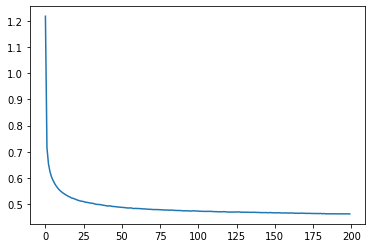

In [29]:
pred = model.predict(train_X)
pred
train_acc = metrics.accuracy_score(train['target'], pred) * 100.
loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [30]:
test

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144363,144364,0,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,0,0,0,0
144364,144365,0,0,0,0,0,0,0,0,0,...,0,1,4,1,11,0,0,0,0,0
144365,144366,0,1,0,0,0,0,1,1,0,...,0,1,3,1,1,0,0,1,0,0
144366,144367,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,0,0,0,1,0


In [31]:
test_X = test.drop('id', axis = 1)
test_prob = model.predict_proba(test_X)
test_prob

array([[1.20519726e-06, 2.38958212e-01, 2.55275179e-01, ...,
        2.28834857e-03, 1.38846110e-09, 1.09827249e-07],
       [3.22922691e-06, 2.88009525e-04, 4.73937793e-05, ...,
        2.94375884e-04, 1.99985300e-01, 1.08709487e-04],
       [5.76446896e-10, 3.07221268e-14, 1.05789776e-14, ...,
        8.14553682e-09, 4.13030094e-08, 1.27271002e-07],
       ...,
       [4.41789819e-08, 4.05023128e-01, 5.45050075e-01, ...,
        8.23165686e-04, 2.60654165e-10, 9.43382338e-16],
       [1.60401193e-06, 4.57968946e-01, 5.92930337e-02, ...,
        6.84429575e-05, 1.41329675e-08, 3.17217271e-04],
       [8.56883752e-05, 4.86120502e-01, 3.96624154e-01, ...,
        4.78549200e-02, 2.33276670e-07, 4.35755734e-07]])

In [32]:
mlp_submission = pd.DataFrame(test_prob, columns=['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])

In [33]:
mlp_submission['id'] = test['id']
cols = mlp_submission.columns.tolist()
cols = cols[-1:] + cols[:-1]
mlp_submission = mlp_submission[cols]
mlp_submission

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,1.205197e-06,2.389582e-01,2.552752e-01,5.033499e-01,3.835943e-09,1.270652e-04,2.288349e-03,1.388461e-09,1.098272e-07
1,2,3.229227e-06,2.880095e-04,4.739378e-05,8.802290e-04,1.385367e-10,7.983928e-01,2.943759e-04,1.999853e-01,1.087095e-04
2,3,5.764469e-10,3.072213e-14,1.057898e-14,1.180261e-08,5.617415e-23,9.999998e-01,8.145537e-09,4.130301e-08,1.272710e-07
3,4,8.795188e-09,8.190644e-01,1.807179e-01,2.100180e-04,4.977194e-12,7.702329e-08,7.607137e-06,1.504380e-11,3.707015e-10
4,5,1.487035e-01,4.379720e-06,2.517532e-09,3.015878e-09,2.111105e-12,1.013816e-06,3.841865e-05,1.086180e-05,8.512419e-01
...,...,...,...,...,...,...,...,...,...,...
144363,144364,2.945059e-01,3.030615e-04,1.996425e-05,1.001036e-04,1.517368e-08,5.499653e-01,1.179781e-01,2.213453e-03,3.491409e-02
144364,144365,5.285518e-04,2.888996e-01,4.161824e-01,1.092296e-01,7.748377e-06,7.690590e-03,1.773956e-01,6.540151e-05,5.128681e-07
144365,144366,4.417898e-08,4.050231e-01,5.450501e-01,4.904602e-02,6.496557e-12,5.756736e-05,8.231657e-04,2.606542e-10,9.433823e-16
144366,144367,1.604012e-06,4.579689e-01,5.929303e-02,4.823242e-01,3.686985e-07,2.621390e-05,6.844296e-05,1.413297e-08,3.172173e-04


In [34]:
mlp_submission.to_csv('mlp_submission.csv', index = False)

# Random Forest Model

In [35]:
rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_features = 50, random_state=123, verbose = 2)
calibrated_rf = calibration.CalibratedClassifierCV(rf_model, method='isotonic', cv=5)


rf = rf_model.fit(train_X, train['target'])
cal_rf = calibrated_rf.fit(train_X, train['target'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.6s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [36]:
train_acc = cal_rf.score(train_X, train['target'])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_job

In [37]:
print('Random Forest LogLoss {score}'.format(score=metrics.log_loss(train['target'], cal_rf.predict_proba(train_X))))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s


Random Forest LogLoss 0.1241194531780739


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


In [38]:
train_acc

0.9989172242153915

<BarContainer object of 93 artists>

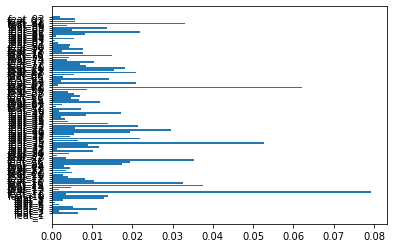

In [39]:
rf_model.feature_importances_
plt.barh(train_X.columns, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

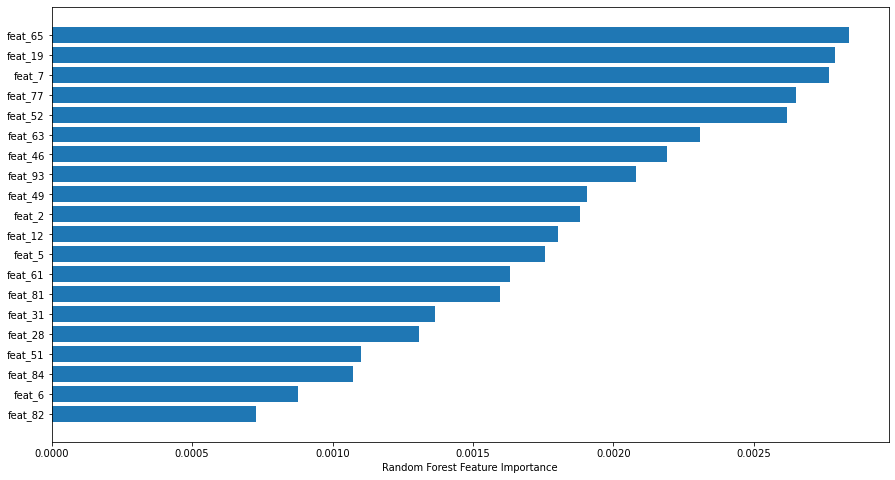

In [40]:
sorted_idx = rf.feature_importances_.argsort()
top_idx = sorted_idx[0:20]
top_idx

plt.figure(figsize=(15,8))
plt.barh(train_X.columns[top_idx], rf.feature_importances_[top_idx])
plt.xlabel("Random Forest Feature Importance")                  

In [41]:
test_result = cal_rf.predict_proba(test_X)
predictions = cal_rf.predict(test_X)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_job

In [42]:
results = pd.DataFrame({'Class_1':test_result[:,0], 'Class_2':test_result[:,1], 'Class_3':test_result[:,2], 'Class_4':test_result[:,3], 'Class_5':test_result[:,4], 'Class_6':test_result[:,5], 'Class_7':test_result[:,6], 'Class_8':test_result[:,7], 'Class_9':test_result[:,8]})
results.insert(0, 'id',range(1,1+len(results)))
results.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.005230,0.120808,0.152946,0.700579,0.000147,0.003309,0.013137,0.001686,0.002159
1,2,0.007410,0.032793,0.021650,0.012907,0.000325,0.461503,0.006619,0.452376,0.004417
2,3,0.000722,0.000182,0.000429,0.001305,0.000176,0.994486,0.001240,0.000924,0.000535
3,4,0.001223,0.625976,0.317930,0.039544,0.000178,0.000871,0.001257,0.000933,0.012089
4,5,0.044887,0.000173,0.000437,0.001307,0.000177,0.028260,0.035258,0.057781,0.831721


In [43]:
results.to_csv("rf_submission.csv")